In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms, Compose
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Step 1. Pytorch Dataset (and DataLoader)

This is why datasets are important:
- It's an organized way to structure how the data and labels are loaded into the model.
- We can then wrap the dataset in a dataloader and pytorch will handle batching the shuffling the data for us when training the model!

In [3]:
class PlayingCardsDataset(Dataset):
	def __init__(self, data_dir: str, transform: Compose | None = None) -> None:
		super(PlayingCardsDataset, self).__init__()
		self.data = ImageFolder(data_dir, transform=transform)
	
	def __len__(self):
		return len(self.data)


	def __getitem__(self, idx):
		return self.data[idx]
	
	@property
	def classes(self):
		return self.data.classes

## Creating a test dataset

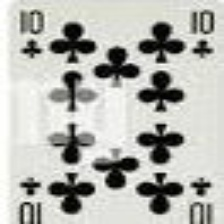

In [7]:
dataset = PlayingCardsDataset(data_dir="./card-image-dataclassification/train/")
image, label = dataset[6000]
image

In [8]:
# Get a dictionary associating target values with a folder names
data_dir = './card-image-dataclassification/train/'
target_to_class = { v: k for k,v in ImageFolder(data_dir).class_to_idx.items() }

target_to_class

{0: 'ace of clubs',
 1: 'ace of diamonds',
 2: 'ace of hearts',
 3: 'ace of spades',
 4: 'eight of clubs',
 5: 'eight of diamonds',
 6: 'eight of hearts',
 7: 'eight of spades',
 8: 'five of clubs',
 9: 'five of diamonds',
 10: 'five of hearts',
 11: 'five of spades',
 12: 'four of clubs',
 13: 'four of diamonds',
 14: 'four of hearts',
 15: 'four of spades',
 16: 'jack of clubs',
 17: 'jack of diamonds',
 18: 'jack of hearts',
 19: 'jack of spades',
 20: 'joker',
 21: 'king of clubs',
 22: 'king of diamonds',
 23: 'king of hearts',
 24: 'king of spades',
 25: 'nine of clubs',
 26: 'nine of diamonds',
 27: 'nine of hearts',
 28: 'nine of spades',
 29: 'queen of clubs',
 30: 'queen of diamonds',
 31: 'queen of hearts',
 32: 'queen of spades',
 33: 'seven of clubs',
 34: 'seven of diamonds',
 35: 'seven of hearts',
 36: 'seven of spades',
 37: 'six of clubs',
 38: 'six of diamonds',
 39: 'six of hearts',
 40: 'six of spades',
 41: 'ten of clubs',
 42: 'ten of diamonds',
 43: 'ten of hear

In [9]:
transform = transforms.Compose([
	transforms.Resize([128, 128]), 
	transforms.ToTensor()
])


data_dir = "./card-image-dataclassification/train/"
dataset = PlayingCardsDataset(data_dir, transform)

In [18]:
image, label = dataset[6666]
image.shape

torch.Size([3, 128, 128])

In [19]:
# iterate over dataset
for image, label in dataset:
    break

## Dataloaders
 - Batching our dataset
 - It's faster to train the model using batches rather than one at a time

In [20]:
dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [21]:
for images, labels in dataloader:
    break

In [22]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [23]:
class CardClassifierModel(nn.Module):
    def __init__(self, num_classes=53) -> None:
        super(CardClassifierModel, self).__init__()

        # Define all parts of the model
        self.base_model = timm.create_model("efficientnet_b0", pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        # The effiecientnet_b0 model has an output of 1280, hence why we are setting the enet_features = 1280
        enet_features = 1280

        # Map the output features to the number of our classes
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(enet_features, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)

        return output

In [57]:
model = CardClassifierModel(num_classes=53)
print(str(model)[:500])

CardClassifierModel(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [25]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

## Step 3. The Training Loop
- Now that we understand the general paradigm of pytorch datasets and models, we need to create the process of training this model.
- Some things to consider: We want to validate our model on data it has not been trained on, so usually we split our data into a train and validate datasets (I have whole videos on this). This is easy because we can just create two datasets using our existing class.
    - Terms:
        - Epoch: One run through the entire training dataset.
        - Step: One batch of data as defined in our dataloader
- This loop is one you will become familiar with when training models, you load in data to the model in batches - then calculate the loss and perform backpropagation. There are packages that package this for you, but it's good to have at least written it once to understand how it works.
- Two things to select:
    - optimizer, `adam` is the best place to start for most tasks.
    - loss function: What the model will optimize for. In this case, since we have Image Classification, CrossEntropyLoss is one of the best if not the best loss function for any type of classification

In [26]:
# Loss Fn
criterion = nn.CrossEntropyLoss() # The best loss function if you have any type of classification

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) 


In [27]:
criterion(example_out, labels)

example_out.shape, labels.shape

(torch.Size([32, 53]), torch.Size([32]))

In [28]:
transform = transforms.Compose([
	transforms.Resize([128, 128]),
	transforms.ToTensor(),
])


test_folder = './card-image-dataclassification/test/'
valid_folder = './card-image-dataclassification/valid/'
train_folder = './card-image-dataclassification/train/'

test_dataset = PlayingCardsDataset(test_folder, transform)
valid_dataset = PlayingCardsDataset(valid_folder, transform)
train_dataset = PlayingCardsDataset(train_folder, transform)


test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [29]:
torch.cuda.is_available()

True

## Simple Training Loop

In [30]:
epochs = 5
train_losses, valid_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CardClassifierModel(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(epochs):
    # Training Phase
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Training Loop"):
        images, labels = images.to(device), labels.to(device) # Move images and labels to be processed by cuda (GPU)
        optimizer.zero_grad()
        outputs = model.forward(images)
        loss = criterion(outputs, labels) # Calculate Loss
        loss.backward() # Backwards Propagation
        optimizer.step()

        running_loss += loss.item() * labels.size(0) # Add loss to global running loss

    train_loss = running_loss / len(train_loader.dataset)  # type: ignore
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Loop"):
            images, labels = images.to(device), labels.to(device)

            outputs = model.forward(images)
            loss = criterion(outputs, labels)
            running_loss = loss.item() * labels.size(0)
    valid_loss = running_loss / len(valid_loader.dataset)  # type: ignore
    valid_losses.append(valid_loss)
    print(
        f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss}, Validation loss: {valid_loss}"
    )

Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5977658776396344, Validation loss: 0.0249097965798288


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5704958163678708, Validation loss: 0.013878354711352655


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.3365393313193246, Validation loss: 0.033876469900023264


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.2593743087330995, Validation loss: 0.018030122765954934


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.19490024620219518, Validation loss: 0.0052895428999414984


## Visualise Losses

We can plot our training and validation loss through this training, usually we do this at the end of each epoch. We see that our accuracy on the validation dataset is `x`! There are a LOT more things to learn about that can drastically improve how to train a model which I will cover in future videos, but this should give you a good start!

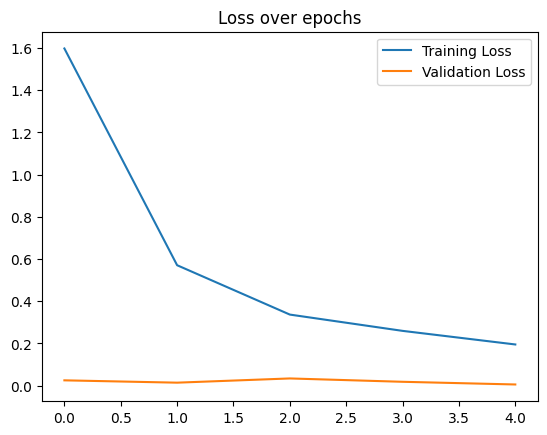

In [33]:
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Evaluating Results

In [55]:
from PIL import Image
from torch import Tensor


class ResultsEvaluation:
    def __init__(self, img_path: str) -> None:
        self.img_path = img_path

    def preprocess_image(self, transform):
        image = Image.open(self.img_path).convert("RGB")
        return image, transform(image).unsqueeze(0)

    def predict(self, model: CardClassifierModel, image_tensor: Tensor, device):
        model.eval()

        with torch.no_grad():
            image_tensor = image_tensor.to(device)
            outputs = model.forward(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            return probabilities.cpu().numpy().flatten()

    def visualise_predictions(self, original_image, probabilities, class_names):
        fig, axarr = plt.subplots(1, 2, figsize=(10, 8))

        # Display Image
        axarr[0].imshow(original_image)
        axarr[0].axis("off")

        # Display predictions
        axarr[1].barh(class_names, probabilities)
        axarr[1].set_xlabel("Probability")
        axarr[1].set_title("Class Predictions")
        axarr[1].set_xlim(0, 1)

        plt.tight_layout()
        plt.show()

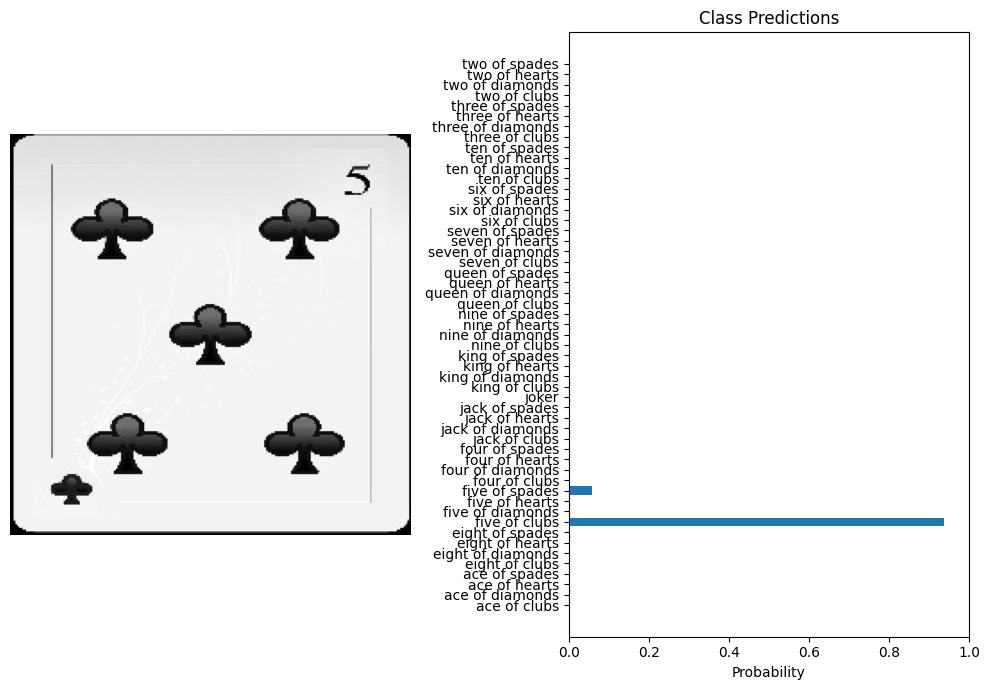

In [54]:
results_evaluation = ResultsEvaluation(
    img_path="./card-image-dataclassification/test/five of clubs/4.jpg"
)

transform = transforms.Compose([
	transforms.Resize((128, 128)), 
	transforms.ToTensor()
])

original_image, image_tensor = results_evaluation.preprocess_image(transform)
probabilities = results_evaluation.predict(
    model=model, image_tensor=image_tensor, device=device
)

# Assuming dataset.classes gives us the dataset classes
class_names = dataset.classes
results_evaluation.visualise_predictions(original_image=original_image, probabilities=probabilities, class_names=class_names)